# Lab1 - Rastreamento visual
## INF0417 - Visão computacional

# 1. Introdução

Neste laboratório você implementará a versão original do famoso algoritmo de Lucas-Kanade para rastreamento de features, o **LK tracker**.

A menos que seja implementado com operações de baixo nível, o algoritmo de rastreamento LK se torna computacionalmente restritivo se tentarmos rastrear cada píxel na imagem.
Assim, nesta atividade vamos restringir a tarefa de rastreamento a somente uma única região (centrada ao redor de um píxel) por vez.
Isso significa que a escolha do píxel a rastrear deve ser feita *sabiamente*.

Além disso, devido à sua estreita relação com o LK tracker, também incorporaremos o detector de Harris (*aka.* Harris-Stephens detector) para encontrar automaticamente features "boas" de serem rastreadas.

## 1.1 Preparação

**Tempo de preparação esperado:** 4-8h

Como preparação para este laboratório, você deverá ler este guia e completar as atividades indicadas com **estrela (*)**.
Parte da preparação consiste em ler e entender o artigo simplificado de rastreamento LK ["Derivation of the Lucas-Kanade Tracker"](./references/2007%20-%20LK-derivation.pdf) \[1\].
Vamos a utilizar a mesma notação do artigo ao fazer perguntas sobre uma expressão em específico ou uma variável, *e.g.*, $T$.
Para completar os exercícios a tempo, é importante estar familiarizado com os diferentes passos envolvidos no algoritmo de rastreamento LK.

O laboratório deverá ser implementado em Python.
Na sala de laboratório do INF, você pode executar o Python desde o prompt no shell do `Ubuntu App`.
Use `python3 <meu_script>.py` para executar um script Python ou, preferencialmente, trabalhe com uma IDE como `vscode` ou `pycharm`.
Se você utiliza múltiplos scripts (recomendado) poderá salvar e carregar dados utilizando o pacote `pickle` ou `np.save/load`.
Para um trabalho mais interativo, você também pode usar `ipython3`, que permite auto-completar comandos com tabs e também conta com  destaque de sintaxe.

Adicionando `from INF0417_labs import lab1` nos seus scripts, você poderá usar o código de suporte para este laboratório.
Este código inclui funções auxiliares, tais como `lab1.load_lab_image` e `lab1.get_cameraman`.
Use `help(lab1)` para obter uma descrição deste pacote.

**Atenção**: Bugs, em códigos científicos, são fáceis de introduzir, mas difíceis de achar.
É uma prática recomendada **ler sempre a documentação** das funções que você usa e, escrever códigos de teste que verificam que elas se comportem conforme o esperado.
Em particular, tome cuidado para não confundir as indexações $(x,y)$ e $(\text{linha}, \text{coluna})$, pois você provavelmente usará ambas neste laboratório.
Em laboratórios futuros, usaremos a $nD$-indexação, com exponencialmente mais maneiras de cometer tais erros.

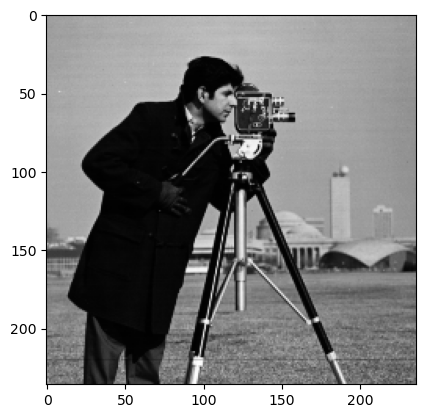

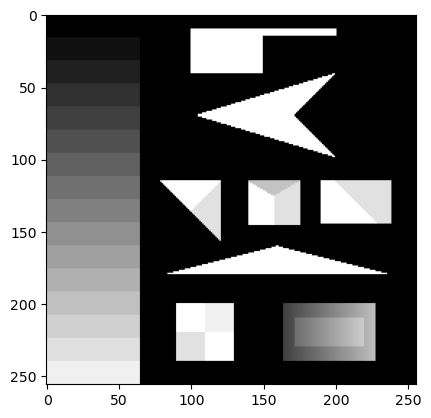

In [2]:
from INF0417_labs import lab1
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Mapa de cores verde-preto-vermelho para os gradientes
gkr_col = np.zeros((255, 4))
gkr_col[:, 3] = 1
gkr_col[:127, 1] = np.linspace(1.0, 0.0, 127, False)
gkr_col[127:, 0] = np.linspace(0.0, 1.0, 128, True)
gkr_col = ListedColormap(gkr_col)

# cameraman
I, J, dTrue = lab1.get_cameraman()
plt.figure()
plt.imshow(I, cmap='gray')
plt.show()

# cornertest
img = lab1.load_lab_image('cornertest.png')
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

# 2. Esboço do algoritmo

Você deverá ter uma estratégia clara sobre como abordar o problema de rastreamento antes de chegar a este laboratório.

**\* Pergunta de preparação**: Desenhe um diagrama de blocos que sintetize os principais passos do algoritmo LK tracker:

In [ ]:
  # segue print do diagrama

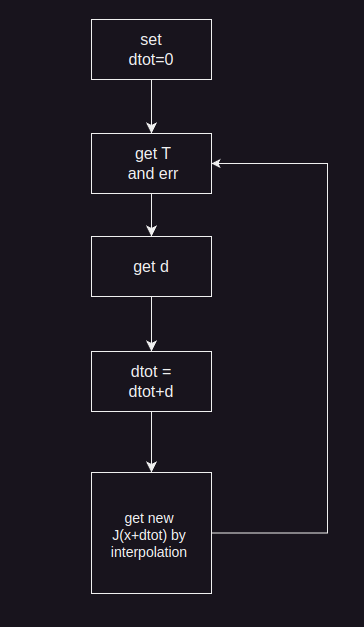


**\* Pergunta de preparação**: Escreva a equação final requerida para atualização do deslocamento:

In [ ]:
# dtot = 0
# d = e*T^(-1)
# dtot = dtot + d


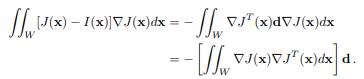

**\* Pergunta de preparação**: Usando a notação em \[1\], explique o que é $T$:

In [ ]:
# T é o tensor de estrutura da imagem J (deslocada)
# T = integral dupla na região W, região ao redor de um pixel, do produto do gradiente
# de J e do gradiente da transposta de J, em du e dv (u e v são dimensões da imagem)

**\* Pergunta de preparação**: O que é requerido de $T$, para que a equação final seja resolvida:

In [ ]:
# é preciso que T seja invertível, (d = e*T^(-1))

**\* Pergunta de preparação**: Dado o seu entendimento sobre o [problema da apertura](./videos/aperture-problem.mp4) ([online](https://youtu.be/vVGorOxMh8w)) e a resposta à pergunta anterior, o que deveria caracterizar um píxel (ou região) escolhido para o rastreamento?

In [ ]:
# o pixel ser um sinal i2d, portanto, um canto.

# 3. O rastreador de Lucas-Kanade

Nesta seção você implementará os blocos necessários para crear seu LK tracker.

## 3.1 Gradiente regularizado

Começamos estimando todas as incógnitas na equação LK.
É útil ter uma função que estime todas elas para garantir que todas tenham a mesma regularização.
Implemente uma função que tenha como entradas o tamanho do filtro e um desvio padrão e, retorne o *gradiente regularizado* e imagens compatíveis.
Uma possível função protótipo é:

`gradiente_regularizado(I, J, kernel_size, sigma) -> Ig, Jg, Jgdx, Jgdy`

**Dica**: Isso foi discutido no laboratório `INF0417_python-tutorial.ipynb` e em \[1\].

In [3]:
from scipy.signal import convolve2d as conv2

def gradiente_regularizado(I, J, kernel_size, sigma):
    x = np.linspace(-(kernel_size//2), kernel_size//2, num=kernel_size)[np.newaxis, :]
    g = np.exp(-x**2 / (2*sigma**2)) #filtro gaussiano
    g = g/np.sum(g) #filtro de gauss normalizado
    df = -x * g /(sigma**2) #direção (df == x, df.T == y)
    
    Ig = conv2(conv2(I, g, mode='same'), g.T, mode='same')
    Jg = conv2(conv2(J, g, mode='same'), g.T, mode='same')
    Jgdx = conv2(conv2(J, df, mode='same'), g.T, mode='same')
    Jgdy = conv2(conv2(J, df.T, mode='same'), g, mode='same') 
    
    return Ig, Jg, Jgdx, Jgdy

In [4]:
kernel_size = 15
sigma = 0.5
Ig, Jg, Jgdx, Jgdy = gradiente_regularizado(I, J, kernel_size, sigma)

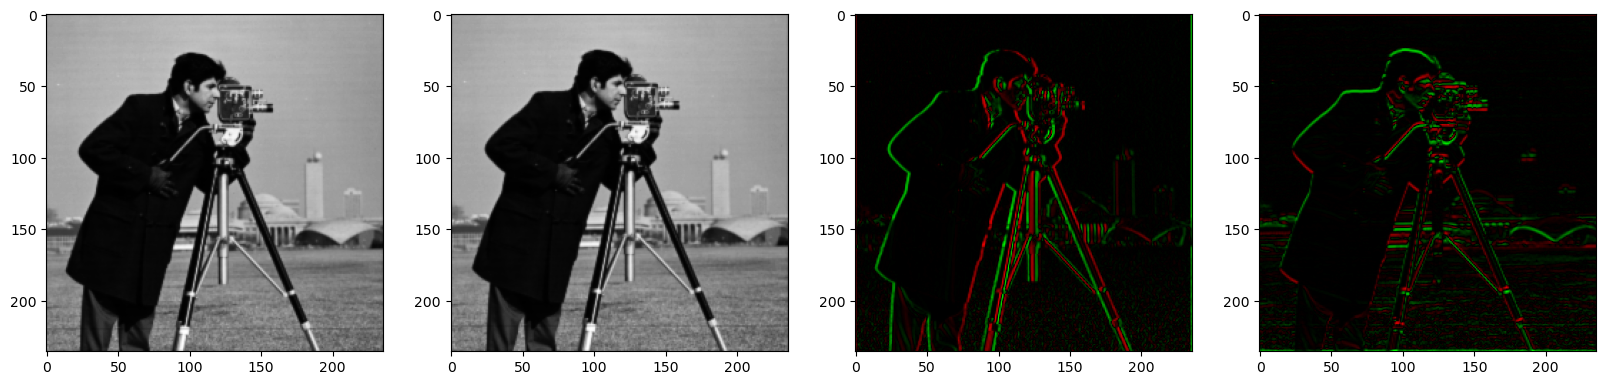

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(Ig, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(Jg, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(Jgdx, vmin = -100, vmax = 100, cmap = gkr_col)
plt.subplot(1, 4, 4)
plt.imshow(Jgdy, vmin = -100, vmax = 100, cmap = gkr_col)
plt.show()

## 3.2 Estimando $T$

Você precisará implementar uma função que estime o tensor de orientação para uma região específica.
Construa a função o mais geral possível, *i.e.*, que permita diferentes tamanhos de janela e também janelas não quadradas.
Uma possível função protótipo é:

`estimar_T(Jgdx, Jgdy, x, y, window_size) -> T`

In [45]:

def estimar_T(Jgdx, Jgdy, x, y, window_size):
    #set roi
    Jgdx = Jgdx[x:x+window_size[0],y:y+window_size[1]]
    Jgdy = Jgdy[x:x+window_size[0],y:y+window_size[1]]
    
    #initialize structural tensor T
    T = np.zeros_like(I[x:x+window_size[0],y:y+window_size[1]])

    T[:, :] = Jgdx * Jgdx
    T[:, :] = Jgdx * Jgdy
    T[:, :] = Jgdy * Jgdy

    return T

In [46]:
estimar_T(Jgdx, Jgdy, 85, 120, (70, 40))


[[  0   7 180 ...   0   1   0]
 [  4  62 158 ...   0   0   1]
 [ 51  35  12 ...   0   0   0]
 ...
 [  0 254 117 ... 120  92  10]
 [124 126  55 ...   1 187   9]
 [176 173  74 ... 136  76   0]]


array([[  0,   7, 180, ...,   0,   1,   0],
       [  4,  62, 158, ...,   0,   0,   1],
       [ 51,  35,  12, ...,   0,   0,   0],
       ...,
       [  0, 254, 117, ..., 120,  92,  10],
       [124, 126,  55, ...,   1, 187,   9],
       [176, 173,  74, ..., 136,  76,   0]], dtype=uint8)

## 3.3 Função de diferenças

Para atualizar o deslocamento com as equações LK precisamos estimar o vetor $e$ para uma região especificada.
Implemente uma função que faça isso.
Faça esta função o mais geral possível, *i.e.*, que permita diferentes tamanhos de janela e também janelas não quadradas.
Uma possível função protótipo é:

`estimar_e(Ig, Jg, Jgdx, Jgdy, x, y, window_size) -> e`

In [60]:
# Escreva aqui sua resposta

def estimar_e(Ig, Jg, Jgdx, Jgdy, x, y, window_size):
    #definir roi
    Ig = Ig[x:x+window_size[0],y:y+window_size[1]]
    Jg = Jg[x:x+window_size[0],y:y+window_size[1]]
    Jgdx = Jgdx[x:x+window_size[0],y:y+window_size[1]]
    Jgdy = Jgdy[x:x+window_size[0],y:y+window_size[1]]
    
    #estimar diferença
    e1 = Ig*Jgdx - Jg*Jgdx
    e2 = Ig*Jgdy - Jg*Jgdy
    #delJ = np.array([Jgdx, Jgdy]) #gradiente da imagem
    #delJ = delJ.T
    e = np.stack((e1,e2))
    #e = diff * delJ
    
    return e

## 3.4 Função de interpolação

Durante as iterações de gradiente descendente, é evidente que precisamos obter valores de intensidade para coordenadas de píxel não inteiras.
Você deve implementar uma função que dê conta disso.
Crie uma função que retorne valores de intensidade interpolados para todas as posições de sub-píxel especificadas por uma região de interesse.
Você pode implementar mais de uma função de interpolação, porém não será necessário para passar esta tarefa.

**Dica**: Use `scipy.interpolate.RectBivariateSpline` para obter uma função de interpolação:

`imgc = RectBivariateSpline(np.arange(img.shape[0]), np.arange(img.shape[1]), img)`

In [ ]:
# Escreva aqui sua resposta

import scipy

def interp_spline(xcoords, ycoords, Jg):
 #abaixo esta errado por enquanto, devo interpolar a imagem com o seu gradiente #xcoords e ycoords irao virar mesmo ranges da imagem :D    imgc = RectBivariateSpline(np.arange(xcoords), np.arange(ycoords), Jg)
    return imgc

**\* Passo de preparação**: Use `RectBivariateSpline` para definir um objeto de interpolação para uma imagem.
Use seu novo objeto para recortar regiões de interesse em uma imagem de teste.
Certifique-se de entender completamente a estrutura da chamada.

## 3.5 Finalizando o LK tracker

Agora que você tem todos os blocos constituintes (a função de derivadas regularizadas, a função do tensor de orientação, a função de diferenças e a função de interpolação) você deve ser capaz de finalizar o LK tracker.
O que você precisa basicamente é resolver a equação de deslocamento e um laço de controle que atualize o vetor de deslocamento até que um critério de parada seja encontrado, *e.g.*, erro suficientemente pequeno ou número máximo de iterações alcançado.

**Dica:** Use `np.linalg.solve` para resolver um sistema de equações lineares.

Verifique que sua implementação funcione corretamente. Para isso, use a função `get_cameraman()` para obter `I`, `J` e `dTrue`.
`I` é a imagem original, `J` é uma versão deslocada da mesma imagem, e `dTrue` é um vetor descrevendo o deslocamento entre as imagens.
Rastreie uma região com `[altura, largura] = [70, 40]` centrada ao redor de `[linha, coluna] = [85, 120]`.
Ao testar sua implementação, seu deslocamento estimado $d$ deveria estar perto de `dTrue`, mesmo após a primeira iteração.
Verifique que a estimativa do deslocamento melhore ao realizar várias iterações.

**Perguntas:** Quais são os deslocamentos estimados após a primeira e segunda iteração? Qual é o deslocamento real?

In [ ]:
# Escreva aqui sua resposta

def estimar_d(I, J, x, y, window_size, maxIter=100, minErr=0.01):
    d_total = np.zeros((2, 1))
    
    height, width = J.shape
    xcoords, ycoords = np.arange(width), np.arange(height)
    
    Ig, Jg, Jgdx, Jgdy = gradiente_regularizado(I, J, 13, 1.5)
    Jgd = Jg
    Jgdxd = Jgdx
    Jgdyd = Jgdy
    
    for _ in range(maxIter):
        
        if np.linalg.norm(d) < minErr:
            break
    
    return d_total

In [ ]:
I, J, dTrue = lab1.get_cameraman()
d = estimar_d(I, J, 120, 85, (40, 70), 2)

print("Estimate d = ", d)
print("True d = ", dTrue)

In [ ]:
# Escreva aqui sua resposta

# Referências

\[1\] Björn Johansson. Derivation of the Lucas-Kanade Tracker. 2007.